In [3]:
#for dealing with dataframes
import pandas as pd
#for dealing with arrays and math functions
import numpy as np
#for datetime format
import datetime as dt
from datetime import datetime

#for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#not sure what this module exactly does but I think its for visualising and the second part\
#you need for portfolio optimisation and efficietn frontier
import cvxopt as opt 
from cvxopt import blas, solvers

#if i decide to use datareader
import pandas_datareader as pdr
from pandas_datareader import data, wb
import pandas_datareader.data as web
#if i decide to use yahoo finance
import yfinance as yf

In [24]:
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        #get stock portfolio weights by dividing random number assigned to each stock with the sum of random numbers
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df

In [25]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

                 BTC-USD     ETH-USD   XRP-USD  USDT-USD    EOS-USD  \
Date                                                                  
2017-12-31  14156.400391  756.732971  2.300570  1.012260   8.765950   
2018-01-01  13657.200195  772.640991  2.391030  1.007280   8.843180   
2018-01-02  14982.099609  884.443970  2.480900  1.004900   9.334710   
2018-01-03  15201.000000  962.719971  3.105370  1.013440  10.227900   
2018-01-04  15599.200195  980.921997  3.196630  1.002530  11.275500   
...                  ...         ...       ...       ...        ...   
2020-08-22  11664.847656  391.384491  0.285386  1.002345   3.325361   
2020-08-23  11774.595703  408.144196  0.289215  1.001976   3.390611   
2020-08-24  11366.134766  384.001038  0.277927  1.002365   3.138529   
2020-08-25  11488.363281  386.466125  0.277491  1.001853   3.125430   
2020-08-27  11301.908203  381.021271  0.263501  1.002533   2.953312   

                BCH-USD     LTC-USD    MCO-USD    BNB-USD  
Date            

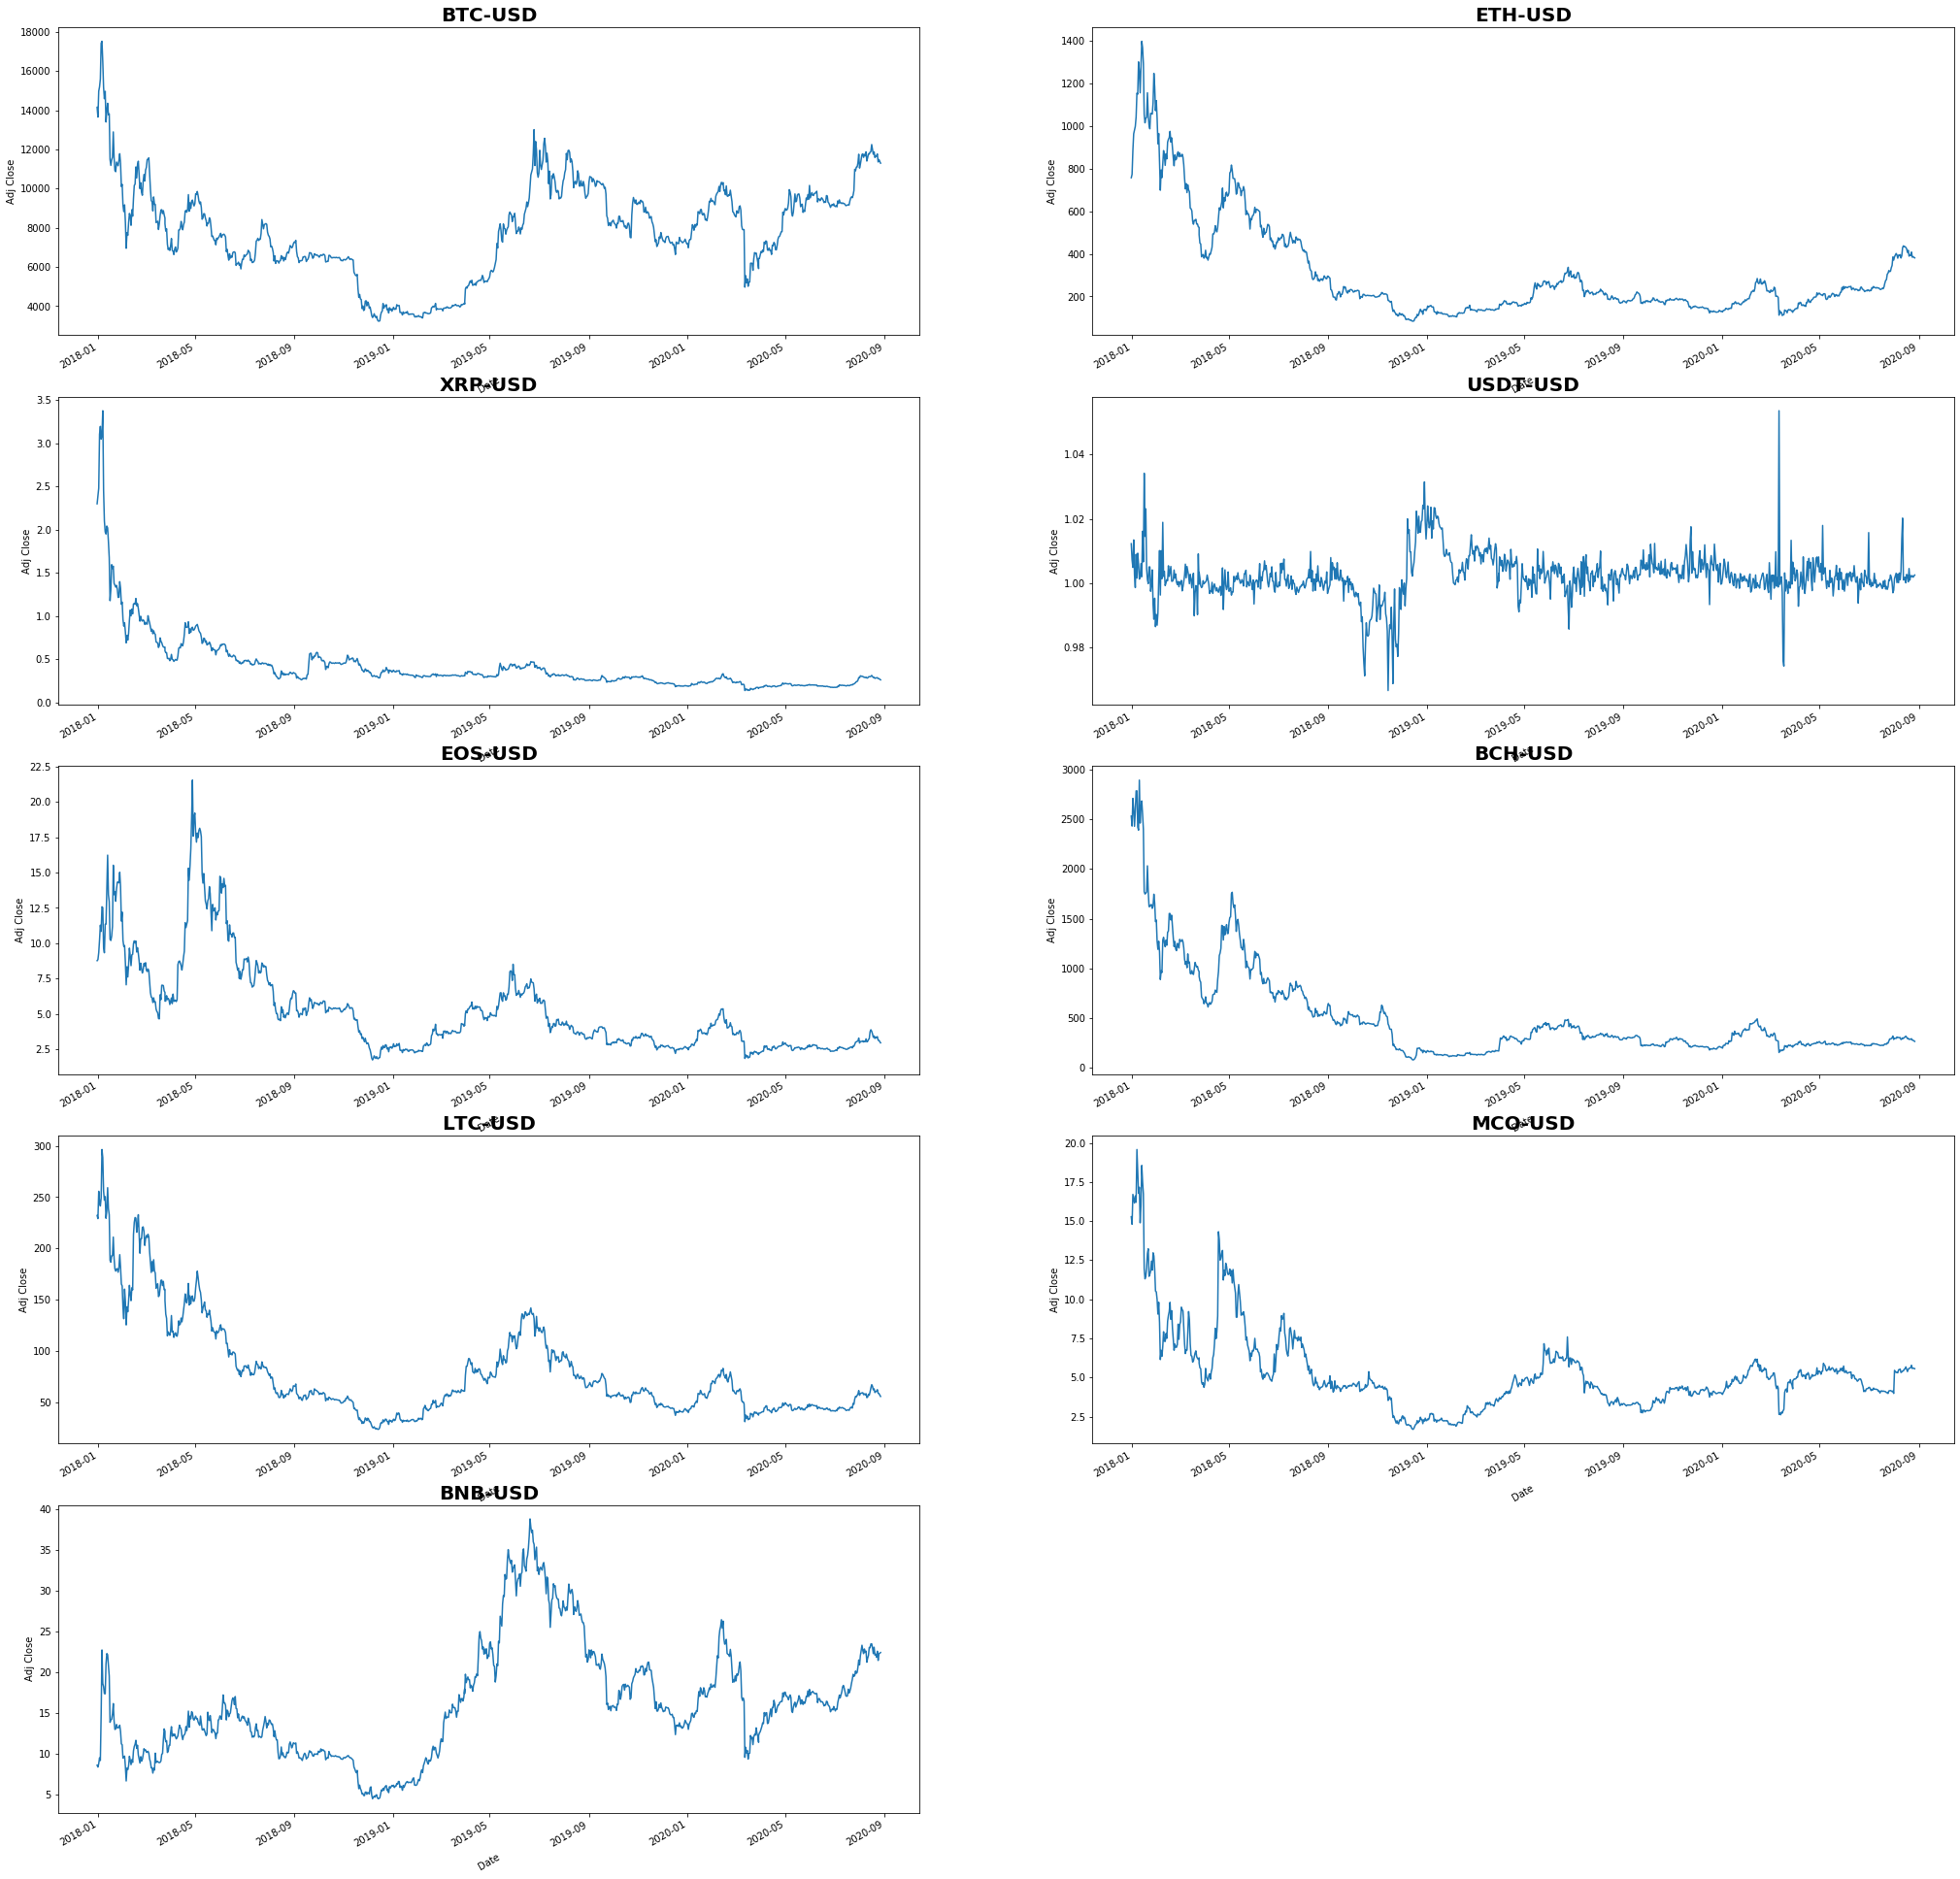

In [33]:
#specify companies and time period
#I have chosen 9 companies that some should be positively / negatively correlated
symbol = ["BTC-USD","ETH-USD", "XRP-USD", "USDT-USD", "EOS-USD", "BCH-USD", "LTC-USD", "MCO-USD", "BNB-USD"]
startdate = datetime(2018,1,1)
enddate = datetime.today()

#Adjusted Close price is closing price adjusted for corporate actions such as stock splits and divs

adjclose = web.DataReader(symbol[0], start=startdate, end=enddate, data_source='yahoo')['Adj Close']
for i in range(1,len(symbol)):
    series = web.DataReader(symbol[i] , start=startdate, end=enddate, data_source='yahoo')['Adj Close']
    adjclose = pd.concat([adjclose, series], axis = 1)
adjclose.columns = symbol
print(adjclose)

plt.figure(figsize = (35, 35))
for i in range(len(symbol)):
    plt.subplot(5, 2, i + 1)
    adjclose[symbol[i]].plot()
    plt.subplots_adjust(bottom = 0.15, wspace=0.2)
    plt.xlabel('Date', rotation=30)
    plt.ylabel('Adj Close')
    plt.title(str(symbol[i]), fontsize = 20, fontweight='bold')
plt.savefig('stockperformance.jpeg')
plt.show()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-12-31,14377.400391,12755.599609,12897.700195,14156.400391,1.213630e+10,14156.400391
2018-01-01,14112.200195,13154.700195,14112.200195,13657.200195,1.029120e+10,13657.200195
2018-01-02,15444.599609,13163.599609,13625.000000,14982.099609,1.684660e+10,14982.099609
2018-01-03,15572.799805,14844.500000,14978.200195,15201.000000,1.687190e+10,15201.000000
2018-01-04,15739.700195,14522.200195,15270.700195,15599.200195,2.178320e+10,15599.200195
...,...,...,...,...,...,...
2020-08-22,11713.429688,11559.920898,11679.696289,11664.847656,1.848206e+10,11664.847656
2020-08-23,11807.631836,11623.250000,11663.689453,11774.595703,2.068151e+10,11774.595703
2020-08-24,11778.299805,11189.850586,11773.588867,11366.134766,2.630151e+10,11366.134766


In [34]:
simpleror = adjclose.pct_change()
print(simpleror)

             BTC-USD   ETH-USD   XRP-USD  USDT-USD   EOS-USD   BCH-USD  \
Date                                                                     
2017-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
2018-01-01 -0.035263  0.021022  0.039321 -0.004920  0.008810 -0.039664   
2018-01-02  0.097011  0.144702  0.037586 -0.002363  0.055583  0.114473   
2018-01-03  0.014611  0.088503  0.251711  0.008498  0.095685 -0.037739   
2018-01-04  0.026196  0.018907  0.029388 -0.010765  0.102426 -0.068429   
...              ...       ...       ...       ...       ...       ...   
2020-08-22 -0.001453 -0.011244 -0.004048  0.001388 -0.013015 -0.008370   
2020-08-23  0.009408  0.042822  0.013416 -0.000369  0.019622  0.022350   
2020-08-24 -0.034690 -0.059154 -0.039031  0.000389 -0.074347 -0.049864   
2020-08-25  0.010754  0.006419 -0.001568 -0.000511 -0.004174 -0.004437   
2020-08-27 -0.016230 -0.014089 -0.050417  0.000679 -0.055070 -0.042147   

             LTC-USD   MCO-USD   BNB-

BTC-USD     0.000582
ETH-USD     0.000588
XRP-USD    -0.000875
USDT-USD    0.000004
EOS-USD     0.000875
BCH-USD    -0.000304
LTC-USD    -0.000132
MCO-USD     0.000908
BNB-USD     0.002628
dtype: float64


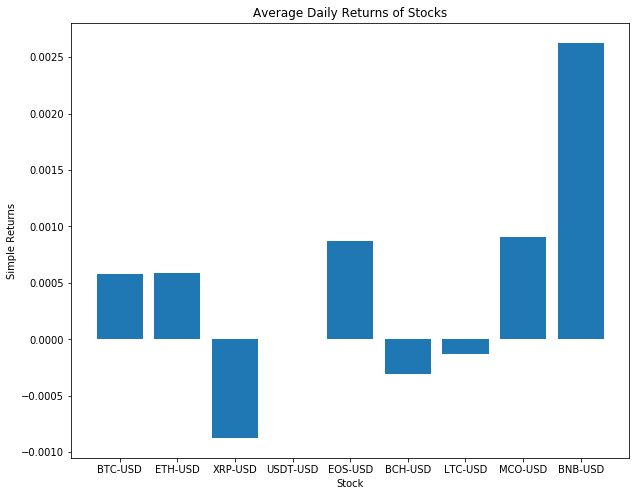

In [35]:
simple_returns = simpleror.mean()
print(simple_returns)
plt.figure(figsize=(10,8))
plt.bar(symbol, simple_returns)
plt.title('Average Daily Returns of Stocks')
plt.xlabel('Stock')
plt.ylabel('Simple Returns')
plt.savefig('dailyreturns.jpeg')
plt.show()

BTC-USD     0.001584
ETH-USD     0.002511
XRP-USD     0.002720
USDT-USD    0.000029
EOS-USD     0.004043
BCH-USD     0.004079
LTC-USD     0.002693
MCO-USD     0.003984
BNB-USD     0.003393
dtype: float64
The riskiest stock in the portfolio, exhibiting a variance of 0.004079123465939001 in daily simple returns over the past 5 years is BCH-USD.


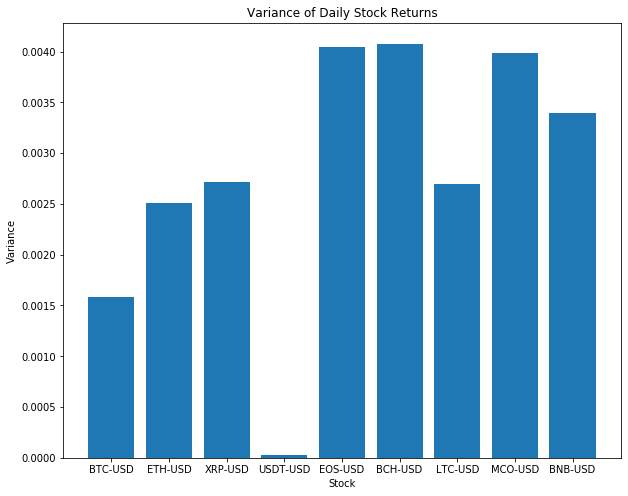

In [36]:
simpleror_var = simpleror.var()
print(simpleror_var)
print('The riskiest stock in the portfolio, exhibiting a variance of {} in daily simple returns over the past 5 years is {}.'.format(max(simpleror_var), simpleror_var.idxmax()))
plt.figure(figsize=(10,8))
plt.bar(symbol, simpleror_var)
plt.title('Variance of Daily Stock Returns')
plt.xlabel('Stock')
plt.ylabel('Variance')
plt.savefig('variance.jpeg')
plt.show()

In [37]:
simpleror_std = simpleror.std()
print(simpleror_std)

BTC-USD     0.039801
ETH-USD     0.050106
XRP-USD     0.052153
USDT-USD    0.005354
EOS-USD     0.063588
BCH-USD     0.063868
LTC-USD     0.051892
MCO-USD     0.063115
BNB-USD     0.058247
dtype: float64


In [38]:
simpleror_cov = simpleror.cov()
print(simpleror_cov)

           BTC-USD   ETH-USD   XRP-USD  USDT-USD   EOS-USD   BCH-USD  \
BTC-USD   0.001584  0.001663  0.001433 -0.000002  0.001834  0.001997   
ETH-USD   0.001663  0.002511  0.002019 -0.000017  0.002445  0.002518   
XRP-USD   0.001433  0.002019  0.002720 -0.000018  0.002347  0.002233   
USDT-USD -0.000002 -0.000017 -0.000018  0.000029 -0.000019 -0.000010   
EOS-USD   0.001834  0.002445  0.002347 -0.000019  0.004043  0.002938   
BCH-USD   0.001997  0.002518  0.002233 -0.000010  0.002938  0.004079   
LTC-USD   0.001675  0.002182  0.001952 -0.000010  0.002525  0.002633   
MCO-USD   0.001576  0.002066  0.001869 -0.000002  0.002237  0.002339   
BNB-USD   0.001515  0.001864  0.001620 -0.000011  0.002143  0.002112   

           LTC-USD   MCO-USD   BNB-USD  
BTC-USD   0.001675  0.001576  0.001515  
ETH-USD   0.002182  0.002066  0.001864  
XRP-USD   0.001952  0.001869  0.001620  
USDT-USD -0.000010 -0.000002 -0.000011  
EOS-USD   0.002525  0.002237  0.002143  
BCH-USD   0.002633  0.002339  0.0

In [39]:
simpleror_corr = simpleror.corr()
#simpleror_corr = simpleror_corr.where(simpleror_corr < 1.00)
print(simpleror_corr)
a, b = simpleror_corr.stack().idxmin()
c, d = simpleror_corr.where(simpleror_corr < 1.00).stack().idxmax()
print('{}/{} exhibits the lowest correlation in daily simple returns.'.format(a, b))
print('{}/{} exhibits the greatest correlation in daily simple returns.'.format(c, d))

           BTC-USD   ETH-USD   XRP-USD  USDT-USD   EOS-USD   BCH-USD  \
BTC-USD   1.000000  0.833798  0.690528 -0.007957  0.724761  0.785624   
ETH-USD   0.833798  1.000000  0.772802 -0.062656  0.767267  0.786751   
XRP-USD   0.690528  0.772802  1.000000 -0.065639  0.707831  0.670508   
USDT-USD -0.007957 -0.062656 -0.065639  1.000000 -0.055668 -0.028236   
EOS-USD   0.724761  0.767267  0.707831 -0.055668  1.000000  0.723474   
BCH-USD   0.785624  0.786751  0.670508 -0.028236  0.723474  1.000000   
LTC-USD   0.811186  0.839337  0.721087 -0.037228  0.765361  0.794413   
MCO-USD   0.627251  0.653192  0.567909 -0.004616  0.557444  0.580194   
BNB-USD   0.653366  0.638537  0.533405 -0.034285  0.578634  0.567663   

           LTC-USD   MCO-USD   BNB-USD  
BTC-USD   0.811186  0.627251  0.653366  
ETH-USD   0.839337  0.653192  0.638537  
XRP-USD   0.721087  0.567909  0.533405  
USDT-USD -0.037228 -0.004616 -0.034285  
EOS-USD   0.765361  0.557444  0.578634  
BCH-USD   0.794413  0.580194  0.5

In [26]:
portfolio_options = return_portfolios(simple_returns, simpleror.cov())
print(portfolio_options)

       Returns  Volatility  BTC-USD Weight  ETH-USD Weight  XRP-USD Weight  \
0     0.001470    0.042247        0.124259        0.068153        0.008924   
1     0.001120    0.039173        0.168358        0.044410        0.157479   
2     0.001022    0.046390        0.148746        0.078198        0.095967   
3     0.000097    0.038216        0.031611        0.222765        0.148456   
4     0.001881    0.047120        0.026659        0.134209        0.062008   
...        ...         ...             ...             ...             ...   
4995  0.001111    0.044490        0.151782        0.057440        0.062369   
4996  0.001222    0.040172        0.128473        0.038319        0.177815   
4997  0.000497    0.038602        0.211443        0.049494        0.211890   
4998  0.000731    0.040486        0.127470        0.010962        0.046897   
4999  0.001622    0.039654        0.129471        0.181913        0.041104   

      USDT-USD Weight  LINK-USD Weight  BCH-USD Weight  LTC-USD

In [40]:
weights, returns, risks = optimal_portfolio(simpleror[1:])

     pcost       dcost       gap    pres   dres
 0: -3.9650e-04 -1.0025e+00  1e+00  2e-16  3e+00
 1: -3.9825e-04 -1.2533e-02  1e-02  8e-17  4e-02
 2: -5.3627e-04 -2.6259e-03  2e-03  1e-16  7e-03
 3: -2.2527e-03 -3.7607e-03  2e-03  8e-16  2e-03
 4: -2.4308e-03 -2.4717e-03  4e-05  1e-16  7e-05
 5: -2.4584e-03 -2.4588e-03  4e-07  1e-16  7e-07
 6: -2.4587e-03 -2.4587e-03  4e-09  2e-16  7e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.8596e-04 -1.0025e+00  1e+00  2e-16  3e+00
 1: -3.8772e-04 -1.2521e-02  1e-02  1e-16  4e-02
 2: -5.2554e-04 -2.6134e-03  2e-03  6e-17  7e-03
 3: -2.2408e-03 -3.7452e-03  2e-03  2e-16  2e-03
 4: -2.4111e-03 -2.4511e-03  4e-05  2e-16  6e-05
 5: -2.4377e-03 -2.4381e-03  4e-07  2e-16  6e-07
 6: -2.4380e-03 -2.4380e-03  4e-09  1e-16  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.7415e-04 -1.0025e+00  1e+00  2e-16  3e+00
 1: -3.7590e-04 -1.2508e-02  1e-02  2e-16  4e-02
 2: -5.1352e-04 -2.5994e

In [28]:
print(weights.shape)
simp_returns = simple_returns.to_numpy().reshape(1,9)
print(simp_returns.shape)
opt_returns = np.asscalar(np.dot(simp_returns, weights))
print(opt_returns)

(9, 1)
(1, 9)
0.006053597564317169


C:\Users\Minh\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  after removing the cwd from sys.path.


In [41]:
stock_data_noGE = pdr.get_data_yahoo(["ETH-USD", "XRP-USD", "USDT-USD", "EOS-USD", "BCH-USD", "LTC-USD", "MCO-USD", "BTC-USD"], startdate, enddate)
stock_data_daily_returns_noGE = stock_data_noGE['Adj Close'].pct_change()
weights_noGE, returns_noGE, risks_noGE = optimal_portfolio(stock_data_daily_returns_noGE[1:]) 

     pcost       dcost       gap    pres   dres
 0: -1.2168e-04 -1.0008e+00  1e+00  2e-16  3e+00
 1: -1.2236e-04 -1.0793e-02  1e-02  7e-17  3e-02
 2: -1.8008e-04 -8.8982e-04  7e-04  3e-17  2e-03
 3: -7.1255e-04 -9.7616e-04  3e-04  3e-16  2e-04
 4: -7.3052e-04 -7.4662e-04  2e-05  1e-16  1e-05
 5: -7.3634e-04 -7.3653e-04  2e-07  2e-16  5e-08
 6: -7.3642e-04 -7.3642e-04  2e-09  2e-16  5e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1114e-04 -1.0008e+00  1e+00  2e-16  3e+00
 1: -1.1182e-04 -1.0779e-02  1e-02  9e-17  3e-02
 2: -1.6948e-04 -8.7545e-04  7e-04  8e-17  2e-03
 3: -6.9258e-04 -9.5190e-04  3e-04  1e-16  2e-04
 4: -7.1047e-04 -7.2867e-04  2e-05  6e-17  1e-05
 5: -7.1706e-04 -7.1730e-04  2e-07  1e-16  6e-08
 6: -7.1717e-04 -7.1718e-04  2e-09  1e-16  6e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9321e-05 -1.0008e+00  1e+00  1e-16  3e+00
 1: -1.0000e-04 -1.0763e-02  1e-02  2e-16  3e-02
 2: -1.5763e-04 -8.5933e

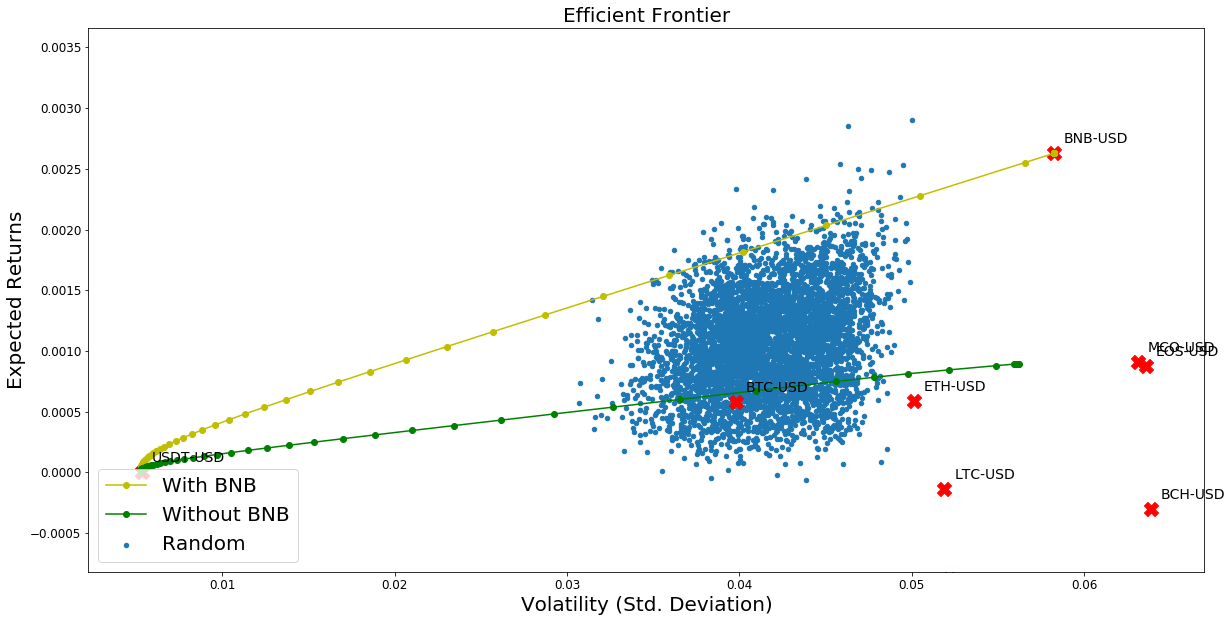

In [43]:
portfolio_options.plot.scatter(x='Volatility', y='Returns', fontsize = 12, figsize=(20,10))
plt.margins(x=0.05, y=-0.3)
plt.xlabel('Volatility (Std. Deviation)', fontsize = 20)
plt.ylabel('Expected Returns', fontsize = 20)
plt.title('Efficient Frontier', fontsize = 20)

#How to put labels right next to the spots?
single_asset_std=np.sqrt(np.diagonal(simpleror_cov))
plt.scatter(single_asset_std,simple_returns,marker='X',color='red',s=200)
for i, txt in enumerate(simpleror.keys()):
    plt.annotate(txt, (single_asset_std[i], simple_returns[i]), size=14, xytext=(10,10), ha='left', textcoords='offset points')
       
plt.plot(risks, returns, 'y-o')
plt.plot(risks_noGE, returns_noGE, 'g-o')
plt.legend(['With BNB', 'Without BNB', 'Random'], fontsize = 20, loc="lower left")

plt.show()

In [53]:
returns_tolerance = np.array([0.00014, 0.0020])
volatility_tolerance = np.array([0.032, 0.044])
df_lower_volatility = portfolio_options[(portfolio_options.Returns > returns_tolerance[0]) & (portfolio_options.Volatility < volatility_tolerance[0])]
df_higher_returns = portfolio_options[(portfolio_options.Returns > returns_tolerance[1]) & (portfolio_options.Volatility < volatility_tolerance[1])]
print(df_lower_volatility)
print(df_higher_returns)

       Returns  Volatility  BTC-USD Weight  ETH-USD Weight  XRP-USD Weight  \
484   0.000459    0.031651        0.237897        0.048723        0.011220   
485   0.001418    0.031464        0.071369        0.119299        0.019179   
965   0.001262    0.031812        0.010433        0.055274        0.036418   
1781  0.000739    0.030750        0.010151        0.024021        0.177812   
3750  0.000360    0.031544        0.161906        0.026573        0.245193   
4231  0.000572    0.030692        0.138752        0.093317        0.067522   
4581  0.000628    0.031738        0.107609        0.120354        0.106871   

      USDT-USD Weight  LINK-USD Weight  BCH-USD Weight  LTC-USD Weight  \
484          0.297659         0.004573        0.140798        0.102826   
485          0.335955         0.096314        0.032096        0.021468   
965          0.337197         0.086157        0.044767        0.068428   
1781         0.343566         0.088599        0.043335        0.164065   
3750 

In [54]:
#return cao nhat
print(portfolio_options.iloc[4502])
#violate thap nhat
print(portfolio_options.iloc[4231])

Returns            0.002333
Volatility         0.039792
BTC-USD Weight     0.165693
ETH-USD Weight     0.018331
XRP-USD Weight     0.007738
USDT-USD Weight    0.196211
LINK-USD Weight    0.287544
BCH-USD Weight     0.077136
LTC-USD Weight     0.032731
MCO-USD Weight     0.025270
BNB-USD Weight     0.189345
Name: 4502, dtype: float64
Returns            0.000572
Volatility         0.030692
BTC-USD Weight     0.138752
ETH-USD Weight     0.093317
XRP-USD Weight     0.067522
USDT-USD Weight    0.333191
LINK-USD Weight    0.057996
BCH-USD Weight     0.132736
LTC-USD Weight     0.069077
MCO-USD Weight     0.051477
BNB-USD Weight     0.055931
Name: 4231, dtype: float64


In [ ]:
#4231 This portfolio is a less risky investment that yields a daily return of 0.000572 and a variance of 0.030692
#4502 This portfolio is suitable if the client is seeking a portfolio with higher returns. The portfolio yields a daily return of 0.002333 and a variance of 0.039792